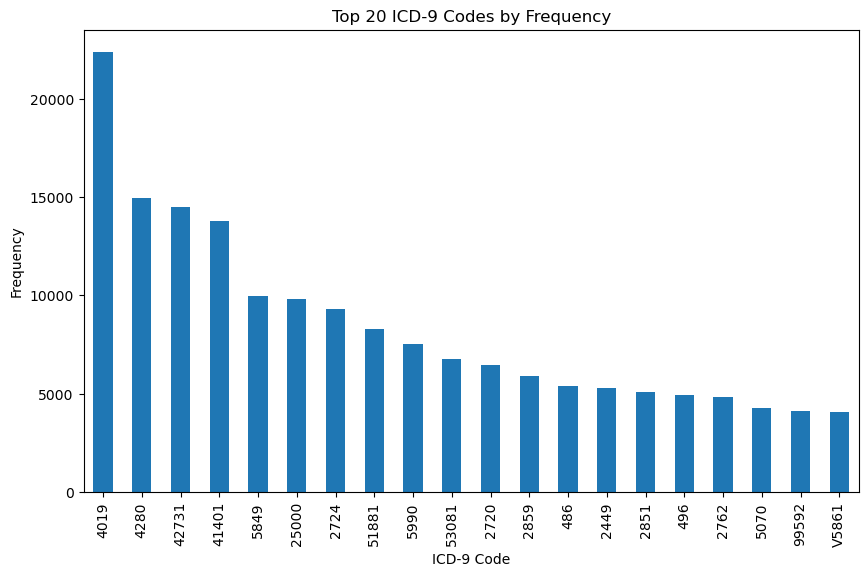

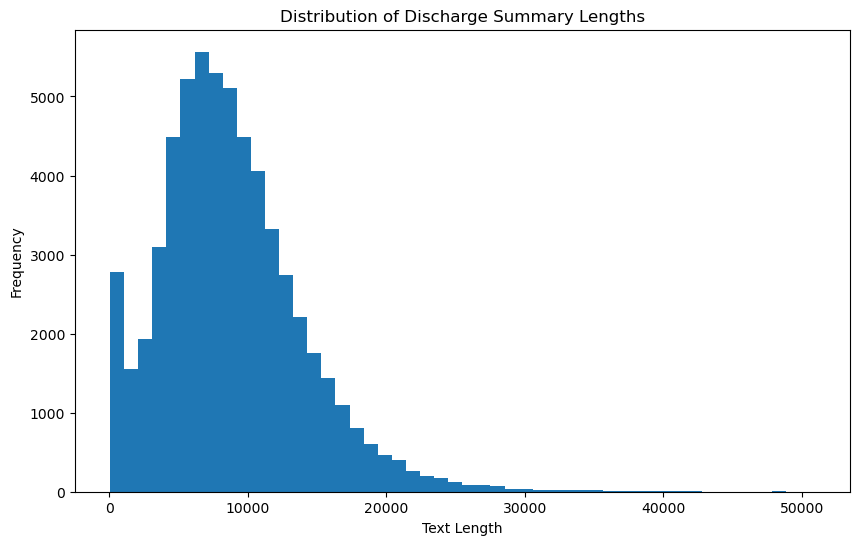

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the necessary tables (assuming CSV or similar format for demonstration)
def load_data(noteevents_path, diagnoses_icd_path):
    noteevents = pd.read_csv(noteevents_path, compression="gzip", low_memory=False)
    diagnoses_icd = pd.read_csv(diagnoses_icd_path, compression="gzip", low_memory=False)
    return noteevents, diagnoses_icd

# Step 1: Extract discharge summaries
def extract_discharge_summaries(noteevents):
    discharge_summaries = noteevents[noteevents['CATEGORY'] == 'Discharge summary']
    return discharge_summaries

# Step 2: Assign ICD-9 codes
def assign_icd9_codes(discharge_summaries, diagnoses_icd):
    grouped_icd = diagnoses_icd.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()
    labeled_data = discharge_summaries.merge(grouped_icd, on='HADM_ID', how='inner')
    return labeled_data

# Step 3: Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in text])
    text = ' '.join(text.split())
    return text

def preprocess_discharge_summaries(discharge_summaries):
    discharge_summaries['CLEAN_TEXT'] = discharge_summaries['TEXT'].apply(preprocess_text)
    return discharge_summaries

# Step 4: Split data
def split_data(labeled_data, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    train, temp = train_test_split(labeled_data, train_size=train_size, random_state=random_state, stratify=labeled_data['ICD9_CODE'].apply(lambda x: x[0]))
    val, test = train_test_split(temp, test_size=test_size/(test_size + val_size), random_state=random_state, stratify=temp['ICD9_CODE'].apply(lambda x: x[0]))
    return train, val, test

# Step 5: Exploratory Data Analysis
def exploratory_data_analysis(labeled_data):
    # ICD-9 Code Frequency
    code_counts = pd.Series([code for codes in labeled_data['ICD9_CODE'] for code in codes]).value_counts()
    
    plt.figure(figsize=(10, 6))
    code_counts.head(20).plot(kind='bar')
    plt.title('Top 20 ICD-9 Codes by Frequency')
    plt.xlabel('ICD-9 Code')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    # Text Length Distribution
    labeled_data['TEXT_LENGTH'] = labeled_data['CLEAN_TEXT'].apply(len)
    
    plt.figure(figsize=(10, 6))
    labeled_data['TEXT_LENGTH'].plot(kind='hist', bins=50)
    plt.title('Distribution of Discharge Summary Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

    return code_counts

# Main Workflow
def main(noteevents_path, diagnoses_icd_path):
    # Load data
    noteevents, diagnoses_icd = load_data(noteevents_path, diagnoses_icd_path)

    # Extract discharge summaries
    discharge_summaries = extract_discharge_summaries(noteevents)

    # Assign ICD-9 codes
    labeled_data = assign_icd9_codes(discharge_summaries, diagnoses_icd)

    # Preprocess text
    cleaned_data = preprocess_discharge_summaries(labeled_data)

    # Split data
    #train, val, test = split_data(labeled_data)

    # Perform EDA
    code_counts = exploratory_data_analysis(labeled_data)

    # Return processed datasets
    return cleaned_data, code_counts

# Example usage
cleaned_data, code_counts = main('../data/raw/NOTEEVENTS.csv.gz', '../data/raw/DIAGNOSES_ICD.csv.gz')
